# Section 4 - Computer vision based machine learning #
## Building CNNs with pyTorch ##

## Dr. Antonin Vacheret (avachere@imperial.ac.uk) 
## High Energy Physics Group
## 523 Blackett Lab

In this second part we will:

Star with: 
* look at the MNIST dataset
* construct datasets, loaders and visualise the data
* Build a MLP to classify the MNIST dataset

and then:
* Build a CNN based on the MNIST dataset features

In [41]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy
import pandas as pd 

We are going to use here the datasets readily available in pytorch using ```torchvision.datasets```. We will need to define if the training set is used to train or test. We will add some transformations that are already available (ToTensor() and Normalise).

In [2]:
train = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
#train = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),
 

Now we have a training sample based on MNIST we can instantiate a dataloader that will be used to provide training data to our model:

In [3]:
train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=10) #we can set the batch size for each interation

It is now possible to visualise easily our dataset using the dataloader and explore:

image shape: torch.Size([10, 1, 28, 28]) 
 label shape: torch.Size([10])


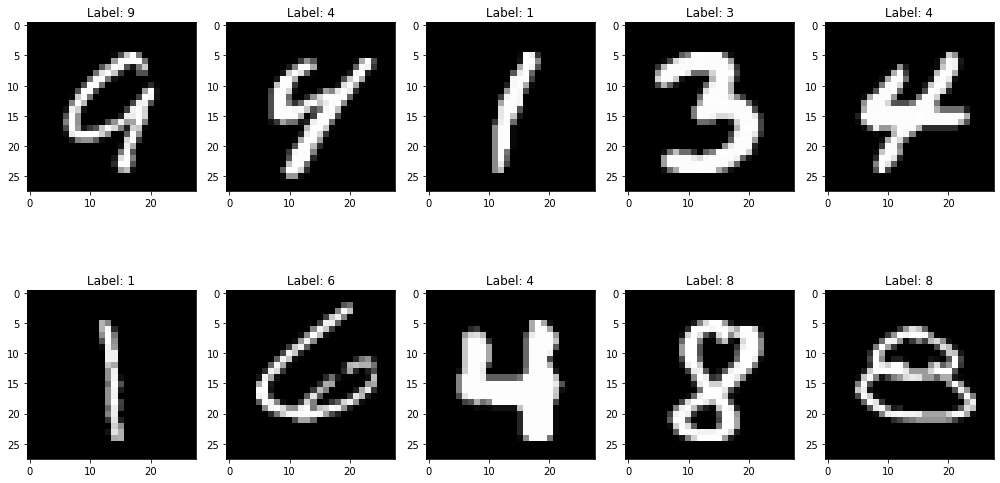

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(14, 8))
ax = ax.flatten()
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("image shape:", images.shape, "\n label shape:", labels.shape)
for i in range(0, 10):
    plottable_image = images[i].squeeze()
    ax[i].imshow(plottable_image, cmap='gray')
    ax[i].set_title("Label: {}".format(labels[i]))
fig.tight_layout()

Exercise: 
* write a Load_MNIST function that load the MNIST dataset both for training and testing and return four sets ```train,test,train_loader, test_loader```.
* write a short function ```visualize_MNIST``` to visualise any number of digits using the dataloader

In [36]:
def load_MNIST():
  """Function to load and normalize MNIST data""" 
  train = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  test = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  print("MNIST dataset loaded and normalized.")
  train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=100)
  test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=False, batch_size=100)
  print("PyTorch DataLoaders loaded.")
  return train, test, train_loader, test_loader

In [8]:
def visualize_MNIST(train_loader):
  """Function to visualize data given a DataLoader object"""
  dataiter = iter(train_loader)
  images, labels = dataiter.next()
  print("image shape:", images.shape, "\n label shape:", labels.shape)
  # visualize data
  fig, ax = plt.subplots(2,5)
  for i, ax in enumerate(ax.flatten()):
      im_idx = np.argwhere(labels == i)[0][0]
      plottable_image = images[im_idx].squeeze()
      ax.imshow(plottable_image)

MNIST datset loaded and normalized.
PyTorch DataLoaders loaded.
image shape: torch.Size([100, 1, 28, 28]) 
 label shape: torch.Size([100])


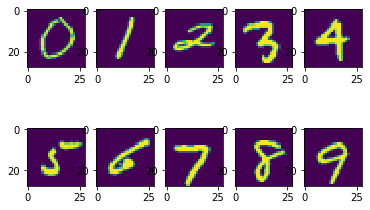

In [9]:
# Load and visualize MNISt
train, test, train_loader, test_loader = load_MNIST()
visualize_MNIST(train_loader)

### Let's now build a MLP based on a few layers

In [10]:
class Net(nn.Module):
    
  def __init__(self):
    super(Net,self).__init__()
    self.input_layer = nn.Linear(784, 1000, bias=False)
    self.hidden1_layer = nn.Linear(1000, 1000, bias=False)
    self.hidden2_layer = nn.Linear(1000, 500, bias=False)
    self.hidden3_layer = nn.Linear(500, 200, bias=False)
    self.hidden4_layer = nn.Linear(200, 10, bias=False)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    x = self.hidden1_layer(x)
    x = F.relu(x)
    x = self.hidden2_layer(x)
    x = F.relu(x)
    x = self.hidden3_layer(x)
    x = F.relu(x)
    x = self.hidden4_layer(x)
    output = F.log_softmax(x, dim=1)

    return output

In [28]:
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (input_layer): Linear(in_features=784, out_features=1000, bias=False)
  (hidden1_layer): Linear(in_features=1000, out_features=1000, bias=False)
  (hidden2_layer): Linear(in_features=1000, out_features=500, bias=False)
  (hidden3_layer): Linear(in_features=500, out_features=200, bias=False)
  (hidden4_layer): Linear(in_features=200, out_features=10, bias=False)
)


(2386000, [784000, 1000000, 500000, 100000, 2000])

2.3M parameters !!! 

We need now to define a training function that will take care of the training sequence

In [23]:
def train(model, train_loader, epochs=3, learning_rate=0.001):
  """Function to train a neural net"""

  lossFunction = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  time0 = time()
  total_samples = 0 

  for e in range(epochs):
    print("Starting epoch", e)
    total_loss = 0

    for idx, (images,labels) in enumerate(train_loader):
      images = images.view(images.shape[0],-1) # flatten
      optimizer.zero_grad() # forward pass
      output = model(images)
      loss = lossFunction(output,labels) # calculate loss
      loss.backward() # backpropagate
      optimizer.step() # update weights

      total_samples += labels.size(0)
      total_loss += loss.item()

      if idx % 100 == 0:
        print("Running loss:", total_loss/ len(train_loader))

  final_time = (time()-time0)/60 
  print("Model trained in ", final_time, "minutes on ", total_samples, "samples")


In [24]:
model = Net()
train(model, train_loader, 3) # 10 epochs

Starting epoch 0
Running loss: 0.0038385494550069173
Running loss: 0.12676242349048455
Running loss: 0.17930862842748563
Running loss: 0.22309607322017352
Running loss: 0.2579779248684645
Running loss: 0.29246875358745456
Starting epoch 1
Running loss: 0.0002218827853600184
Running loss: 0.026624268892531593
Running loss: 0.051327713147426644
Running loss: 0.07771997940726579
Running loss: 0.10249545644658307
Running loss: 0.12612930547756454
Starting epoch 2
Running loss: 0.00020371032257874807
Running loss: 0.019230631329119206
Running loss: 0.04061671435522536
Running loss: 0.05909980909898877
Running loss: 0.07787187367600078
Running loss: 0.09454253256864224
Model trained in  0.666598649819692 minutes on  180000 samples


In [25]:
def test(model, test_loader):
  """Test neural net"""

  correct = 0
  total = 0 

  with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
      images = images.view(images.shape[0],-1) # flatten
      output = model(images)
      values, indices = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (labels == indices).sum().item()

    acc = correct / total * 100
    # print("Accuracy: ", acc, "% for ", total, "training samples")

  return acc


In [26]:
acc = test(model, test_loader)
print("The accuracy of our vanilla NN is", acc, "%")

The accuracy of our vanilla NN is 95.19999999999999 %


### Building a CNN classifier to compare

In [42]:
batch_size = 128
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x



In [48]:
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


(21840, [250, 10, 5000, 20, 16000, 50, 500, 10])

In [43]:
train, test, train_loader, test_loader = load_MNIST()

MNIST dataset loaded and normalized.
PyTorch DataLoaders loaded.


In [44]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [45]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [47]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.358330
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.325604
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.426788
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.247547
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.172900
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.346222

Test set: Average loss: 0.0014, Accuracy: 9682/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.310042
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.231027
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.342012
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.277339
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.188407
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.334497

Test set: Average loss: 0.0012, Accuracy: 9722/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.217918
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.343809
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.177870
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.304612
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.130887
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.